In [17]:
import sys
sys.path.append('../lib')
from simulations import simulate_trajectory
from models import G_Maxwell, G_Kelvin_Voigt, G_fractional_Kelvin_Voigt, PSD
from analyze_data import powerspectrum,initial_guess_localy_linear_fractional_kelvin_voigt, initial_guess_maxwell, initial_guess_kelvin_voigt, initial_guess_fractional_kelvin_voigt, fit_maxwell, fit_kelvin_voigt, fit_fractional_kelvin_voigt
import matplotlib.pyplot as plt
import numpy as np
from data_handeling import Data

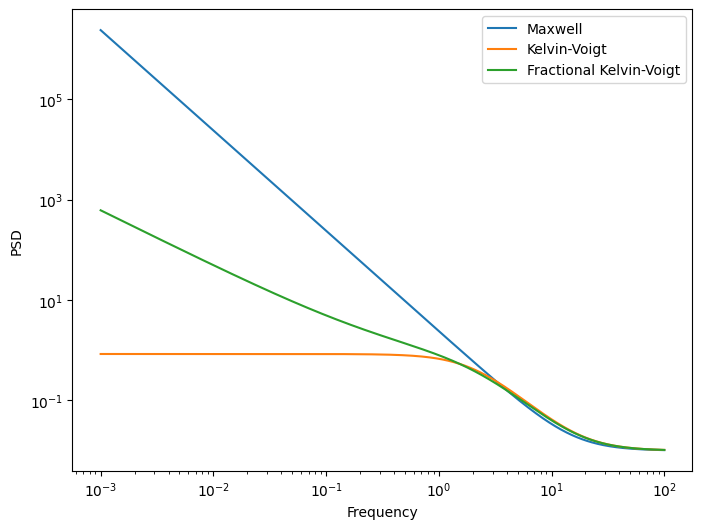

In [18]:
#plot the PSD of the idfferent models
fig, ax = plt.subplots(1,1, figsize=(8,6))
min_freq = 0.001
max_freq = 100
freq = np.logspace(np.log10(min_freq), np.log10(max_freq), 1000)
A = 1.2
B = 0.6
alpha = .11
beta = 1
noise = 0.01
PSD_maxwell = PSD(freq, G_Maxwell, [A, B,noise])
plt.plot(freq, PSD_maxwell, label='Maxwell')
PSD_kv = PSD(freq, G_Kelvin_Voigt, [A, B,noise])
plt.plot(freq, PSD_kv, label='Kelvin-Voigt')
PSD_fkv = PSD(freq, G_fractional_Kelvin_Voigt, [A, B, alpha, beta, noise])
plt.plot(freq, PSD_fkv, label='Fractional Kelvin-Voigt')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.show()

In [19]:
simulation_time =int( 1/min_freq)
sampling_steps = int(simulation_time*max_freq*2)

maxwell_data = Data(*simulate_trajectory(simulation_time,sampling_steps, G_Maxwell, [A, B, noise]), name='Maxwell')
kelvin_voit_data= Data(*simulate_trajectory(simulation_time,sampling_steps, G_Kelvin_Voigt, [A, B, noise]), name='Kelvin-Voigt')
fractional_kelvin_voigt_data=Data(*simulate_trajectory(simulation_time,sampling_steps, G_fractional_Kelvin_Voigt, [A, B, alpha, beta, noise]), name='Fractional Kelvin-Voigt')

Data_list = [maxwell_data, kelvin_voit_data, fractional_kelvin_voigt_data]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


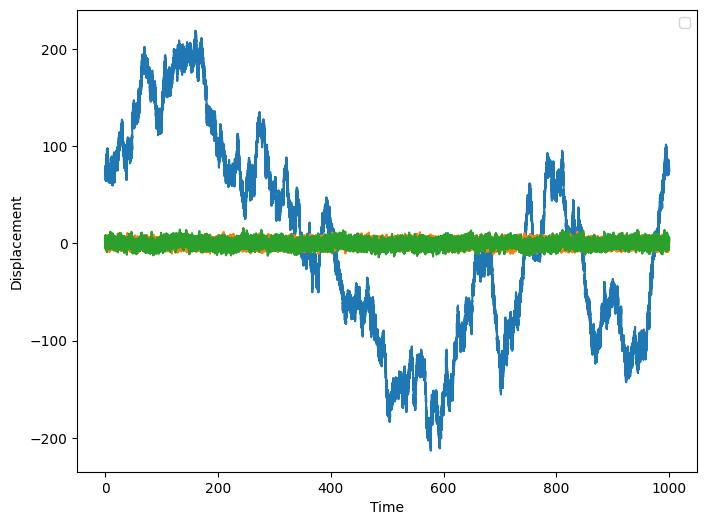

In [20]:
#plot the trajectory    
fig, ax = plt.subplots(1,1, figsize=(8,6))
for data in Data_list:
    data.plot_x(ax)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.show()

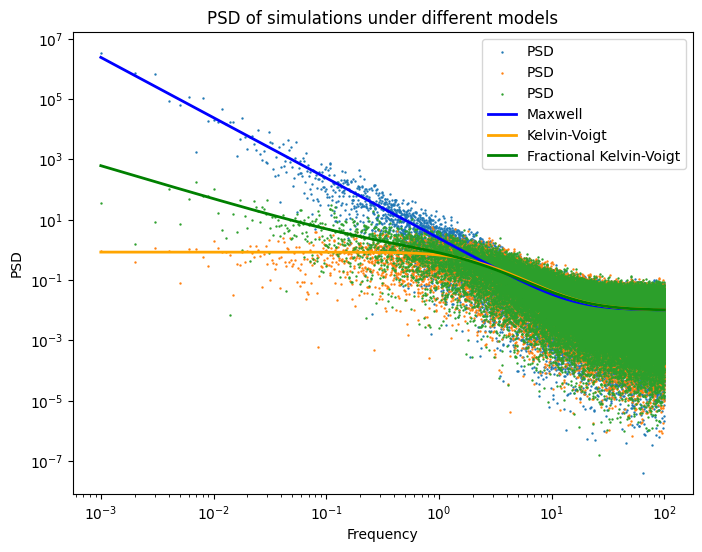

In [21]:
for data in Data_list:
    data.create_PSD()
#plot the PSD of the idfferent models
point_size = .5
fig, ax = plt.subplots(1,1, figsize=(8,6))
for data in Data_list:
    data.plot_psd(ax)
plt.plot(freq, PSD_maxwell, color = "blue",linewidth = 2, label='Maxwell')
plt.plot(freq, PSD_kv, color = "orange",linewidth = 2, label='Kelvin-Voigt')
plt.plot(freq, PSD_fkv, color = "green",linewidth = 2, label='Fractional Kelvin-Voigt')
plt.title('PSD of simulations under different models')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.show()


In [22]:
#make all the fits for all the data
for data in Data_list:
    data.create_NLL_maxwell()
    data.create_NLL_kelvin_voigt()
    data.create_NLL_fractional_kelvin_voigt()

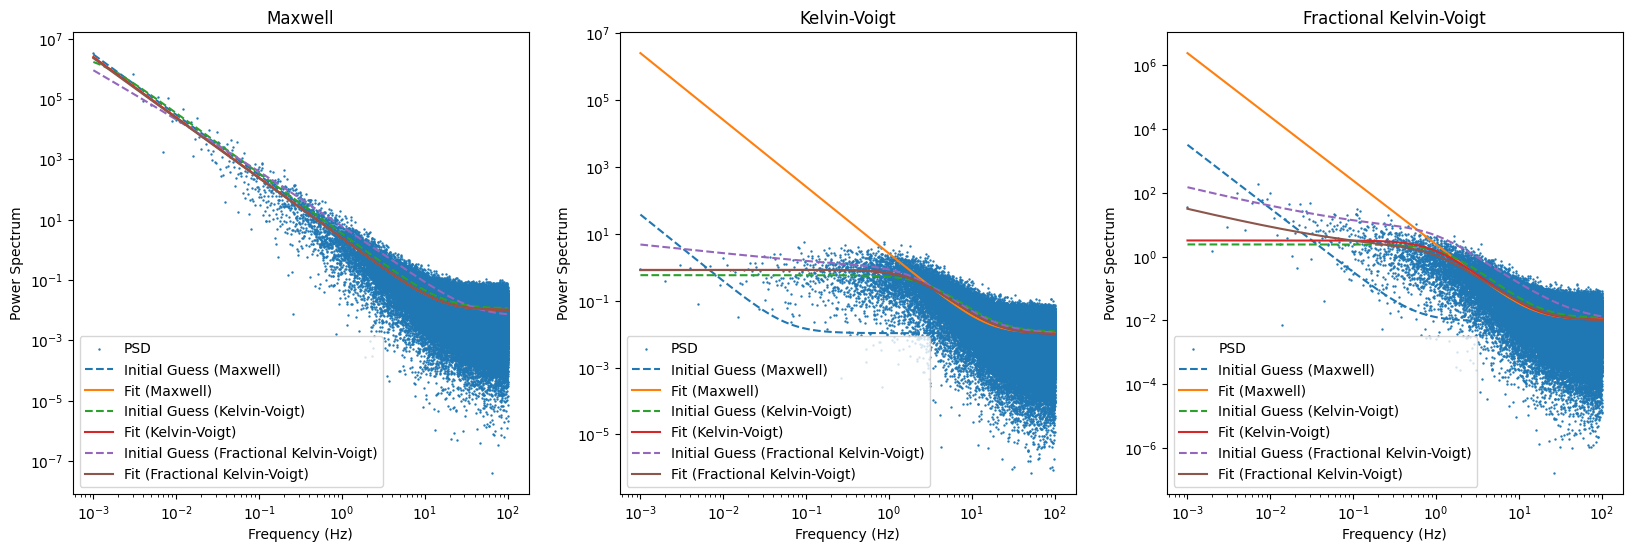

In [23]:
#make one plot for each data in a row. In each plot, plot the data and the fits

fig, ax = plt.subplots(1,3, figsize=(20,6))
data_names = ['Maxwell', 'Kelvin-Voigt', 'Fractional Kelvin-Voigt']
for i, data in enumerate(Data_list):
    #make title
    ax[i].set_title(data_names[i])
    data.plot_psd(ax[i])
    

In [24]:
from analyze_data import localy_linear_approximation,PSD, Laplace_NLL
from scipy.optimize import minimize

In [25]:
data = Data_list[2]
f_array = data.frequencies
PSD_array = data.PSD
linear_guess = initial_guess_localy_linear_fractional_kelvin_voigt(f_array, PSD_array)
initital_gues = initial_guess_fractional_kelvin_voigt(f_array, PSD_array)

def target_funciton(x,*params):
        return PSD(x,G_fractional_Kelvin_Voigt,params)
result = minimize(Laplace_NLL, initital_gues, args=(f_array, PSD_array, target_funciton), method='Nelder-Mead')


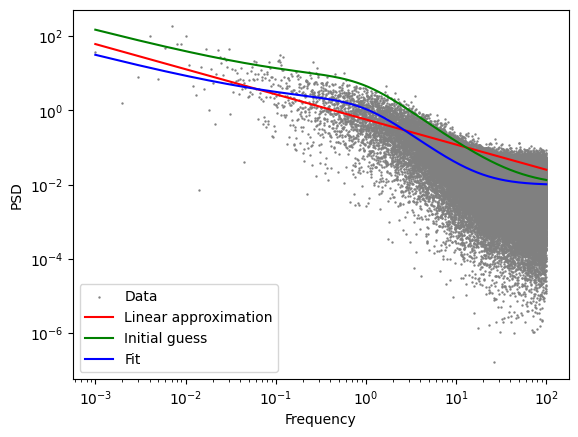

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: -312028.74987626047
             x: [ 6.297e+00 -6.315e+00 -1.097e-01 -2.899e-01  9.886e-03]
           nit: 636
          nfev: 1000
 final_simplex: (array([[ 6.297e+00, -6.315e+00, ..., -2.899e-01,
                         9.886e-03],
                       [ 6.297e+00, -6.322e+00, ..., -2.904e-01,
                         9.871e-03],
                       ...,
                       [ 6.187e+00, -6.198e+00, ..., -2.911e-01,
                         9.879e-03],
                       [ 6.181e+00, -6.204e+00, ..., -2.930e-01,
                         9.890e-03]]), array([-3.120e+05, -3.120e+05, -3.120e+05, -3.120e+05,
                       -3.120e+05, -3.120e+05]))


In [26]:
plt.scatter(f_array, PSD_array, s=0.5, label='Data',c = "grey")
plt.plot(f_array,localy_linear_approximation(f_array, *linear_guess), label='Linear approximation',c = 'red')
plt.plot(f_array,target_funciton(f_array, *initital_gues), label='Initial guess',c = 'green')
plt.plot(f_array,target_funciton(f_array, *result.x), label='Fit',c = 'blue')


plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.show()

print(result)

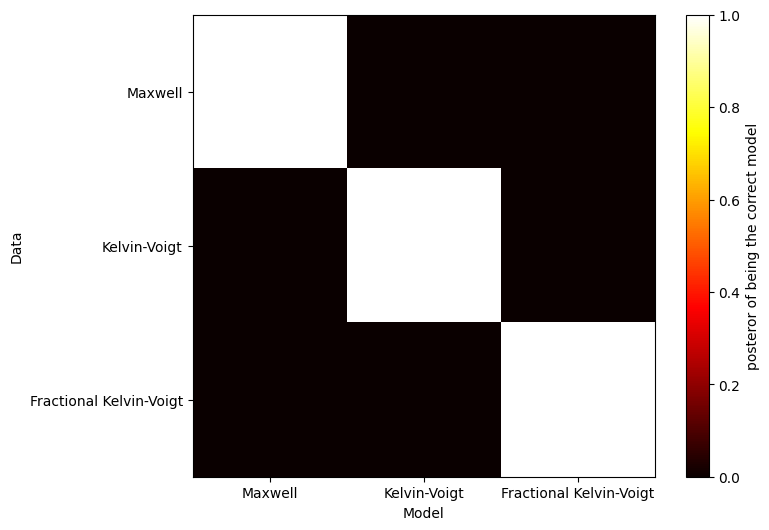

In [28]:
#make a matrix colormap with data on the one axis and models on the other axis. In each cell, plot the NLL of the model for the data
posteror_matrix = np.zeros((len(Data_list),3))
for i, data in enumerate(Data_list):
    data.bayesian_update()
    posteror_matrix[i,0] = data.posterior_maxwell
    posteror_matrix[i,1] = data.posterior_kelvin_voigt
    posteror_matrix[i,2] = data.posterior_fractional_kelvin_voigt

fig, ax = plt.subplots(1,1, figsize=(8,6))
im = ax.imshow(posteror_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(im, ax=ax, label='posteror of being the correct model')
plt.xlabel('Model')
plt.ylabel('Data')
plt.xticks([0,1,2], ['Maxwell', 'Kelvin-Voigt', 'Fractional Kelvin-Voigt'])
plt.yticks([0,1,2], ['Maxwell', 'Kelvin-Voigt', 'Fractional Kelvin-Voigt'])
plt.show()
